In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from geopy.geocoders import Nominatim
from geopy.distance import distance
from typing import Optional

In [3]:
def locate_and_offset(
    location_text: Optional[str] = None,
    offset_miles: Optional[float] = None,
    offset_direction: Optional[str] = None
) -> dict:
    """Process location from photo/text and compute optional offset."""
    geolocator = Nominatim(user_agent="streamlit-location-app")
    
    result = {
        "found_location": None,
        "found_latitude": None,
        "found_longitude": None,
        "offset_applied": False,
        "offset_bearing_degrees": None,
        "offset_miles": None,
        "offset_latitude": None,
        "offset_longitude": None,
        "error": None
    }

    # Try to determine location
    loc = geolocator.geocode(location_text)
    if loc:
        result.update({
            "found_location": loc.address,
            "found_latitude": loc.latitude,
            "found_longitude": loc.longitude
        })
    else:
        result["error"] = f"Could not geocode: {location_text}"
        return result
    

    # Process offset if requested
    if offset_miles and offset_direction:
        direction_map = {
            "north": 0.0, "east": 90.0,
            "south": 180.0, "west": 270.0,
            # Add more directions as needed
        }
        bearing = direction_map.get(offset_direction.lower())
        if bearing is None:
            result["error"] = f"Invalid direction: {offset_direction}"
            return result

        # Calculate new point
        origin = (result["found_latitude"], result["found_longitude"])
        dist_obj = distance(miles=offset_miles)
        new_point = dist_obj.destination(point=origin, bearing=bearing)
        
        result.update({
            "offset_applied": True,
            "offset_bearing_degrees": bearing,
            "offset_miles": offset_miles,
            "offset_latitude": new_point.latitude,
            "offset_longitude": new_point.longitude
        })

    return result

In [4]:
from langchain_openai import ChatOpenAI

# Binding tools to the model
tools = [locate_and_offset]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing scraping scripts with scrapegraphai")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

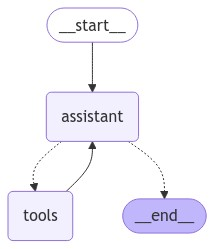

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Find me the location 5 km north to treviglio")]

messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find me the location 5 km north to treviglio
================================== Ai Message ==================================
Tool Calls:
  locate_and_offset (call_Zbc2kpg6j7quqU9KoQBdcfcE)
 Call ID: call_Zbc2kpg6j7quqU9KoQBdcfcE
  Args:
    location_text: Treviglio
    offset_miles: 3.107
    offset_direction: north
================================= Tool Message =================================
Name: locate_and_offset

{"found_location": "Treviglio, Bergamo, Lombardia, 24047, Italia", "found_latitude": 45.5217245, "found_longitude": 9.5931485, "offset_applied": true, "offset_bearing_degrees": 0.0, "offset_miles": 3.107, "offset_latitude": 45.56671391204646, "offset_longitude": 9.5931485, "error": null}
================================== Ai Message ==================================

The location 5 km (approximately 3.107 miles) north of Treviglio is at latitude 45.5667139 and longitude 9.5931485.
